# Анализ результатов А/А и А/В - тестов в мессенджере

В мессенджере команда ML сделала некоторые новые алгоритмы рекомендаций новостей в ленте. Естественно, ожидается, что новые алгоритмы сделают пользователей счастливее, а продукт удобнее/приятнее в использовании. 

**Задача:**
1. Проверить корректно ли работает наша система сплитования.
2. Проверить гипотезу, что новый алгоритм приведет к увеличению CTR.

## Библиотеки

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats # статистика
%matplotlib inline

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

## АА-тест

АА-тест проводился в период с `2023-06-23` по `2023-06-29`. Эксперементальные группы - 2 и 3. Выгрузим данные из базы.

In [3]:
q = """
SELECT exp_group, 
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2023-06-23' and toDate(time) <= '2023-06-29'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727


In [5]:
group_A1 = df[df['exp_group'] == 2].copy()
group_A2 = df[df['exp_group'] == 3].copy()

Проведем симуляцию 10000 АА-тестов:

In [6]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


В группе 2 и 3 примерно одинаковое число пользователей. Построим гистограмму распределения ctr обеих групп.

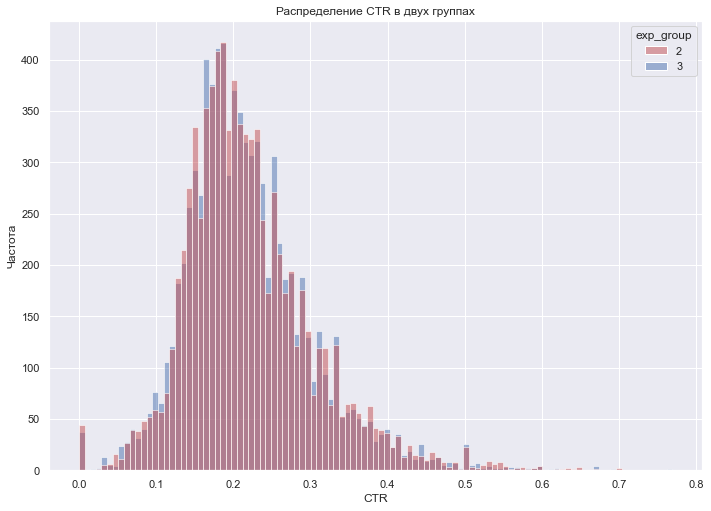

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.title('Распределение CTR в двух группах')
plt.show()

Визуально распределения ctr двух групп похожи.

In [8]:
#функция для проведения одного t-теста
def run_aa_test_with_t_test(group_A1, group_A2):
    group_A1_users = group_A1.sample(500, replace=False)
    group_A2_users = group_A2.sample(500, replace=False)
    ctr_A1 = group_A1_users['ctr'] 
    ctr_A2 = group_A2_users['ctr'] 
    p_value = stats.ttest_ind(ctr_A1,ctr_A2, equal_var=False)[1]
    return p_value

In [9]:
# считаем p_values для 10 000 тестов
num_simulations = 10000
p_values = [run_aa_test_with_t_test(group_A1, group_A2) for _ in range(num_simulations)]

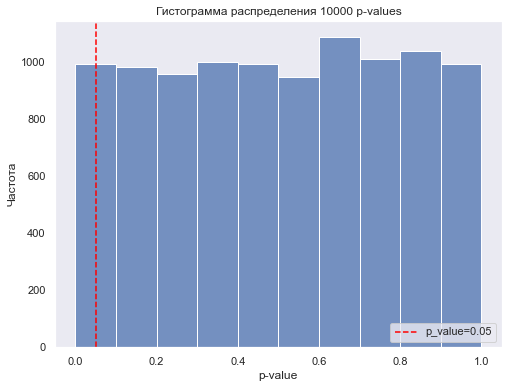

In [10]:
sns.set(rc={'figure.figsize':(8,6)})

groups = sns.histplot(p_values, bins=10,
              kde=False)
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.title('Гистограмма распределения 10000 p-values')
plt.axvline(x=0.05, color='red', linestyle='--', label='p_value=0.05')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

Распределение p_value близко к равномерному.

In [11]:
print('Количество p_value меньше или равное 0,05:', \
      sum(np.array(p_values) <  0.05)/len(p_values)*100, '%')

Количество p_value меньше или равное 0,05: 4.8500000000000005 %


### Вывод

В результате 10 000 А/А- тестов p_value меньше или равно 0,05 не более, чем в 5% случаях. Таким образом, можно считать, что наша система сплитования работает корректно и различия между CTR групп может быть обусловлено случайными факторами.

Данные результаты говорят в пользу того, что проведение дальнейших А/В-тестов с использованием этой системы сплитования будет надежным и достоверным способом оценки влияния изменений на поведение пользователей.

## Анализ A/B - теста

Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно. 

Для эксперимента были задействованы 1 и 2 группы:

- в группе **2** был использован один из **новых алгоритмов рекомендации постов** (рекомендации "похожих на лайкнутые постов") 
- группа **1** использовалась **в качестве контроля**. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 


In [12]:
# выгружаем рабочую таблицу
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
group_A = df[df['exp_group'] == 1].copy()
group_B = df[df['exp_group'] == 2].copy()

In [13]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


Группы поделены примерно на одинаковое число пользователей.

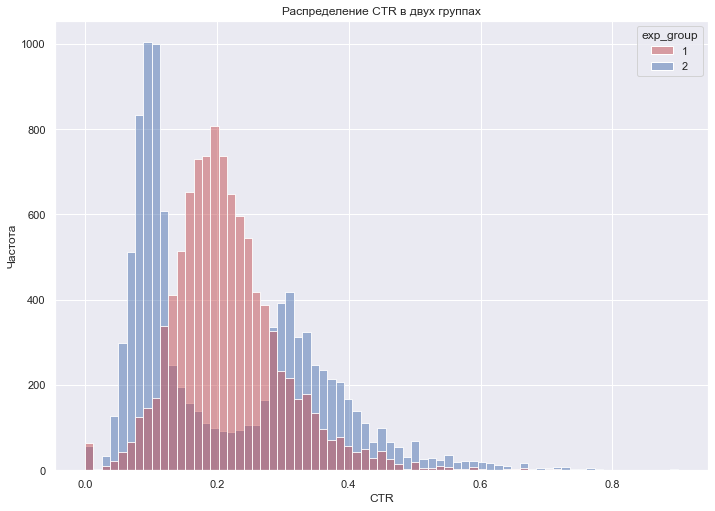

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.title('Распределение CTR в двух группах')
plt.show()

In [15]:
#глобальные CTR
group_A.likes.sum()/group_A.views.sum(), group_B.likes.sum()/group_B.views.sum()

(0.2096041628394293, 0.20025051027061783)

In [16]:
# среднее
group_A.ctr.mean(), group_B.ctr.mean()

(0.21677399412007345, 0.21610168932377813)

In [17]:
# медиана
group_A.ctr.median(), group_B.ctr.median()

(0.2058823529411764, 0.1532846715328467)

**Вывод:** Распределение 2 группы пользователей имеет два ярко выраженных пика. Возможно во 2 группу можно поделить на 2 подгруппы с разным поведением, характерным CTR. 
Таким образом, так как распределение CTR 2 группы достаточно сильно отличается от нормального, то более эффективным может быть тест Манна-Уитни, чем t-тест.

###  t-тест

In [18]:
result = stats.ttest_ind(group_A.ctr,
                         group_B.ctr,
                         equal_var=False)
result

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [19]:
if result.pvalue <= 0.05:
    print("Статистически значимые различия в CTR пользователей между группами есть.")
else:
    print("Статистически значимых различий в CTR пользователей между группами нет.") 

Статистически значимых различий в CTR пользователей между группами нет.


###  Тест Манна-Уитни:

In [20]:
result = stats.mannwhitneyu(group_A.ctr, 
                   group_B.ctr,
                   alternative = 'two-sided')
result

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [21]:
if result.pvalue <= 0.05:
    print("Статистически значимые различия в CTR пользователей между группами есть.")
else:
    print("Статистически значимых различий в CTR пользователей между группами нет.") 

Статистически значимые различия в CTR пользователей между группами есть.


### Пуассоновский бутстреп для подсчета разницы в CTR

In [22]:
# функция подсчета глобального CTR для двух групп методом Пуассоновского бутстрепа
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    # из распределения Пуассона генерируем вес пользователя 
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    # считаем глобальные CTR
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [23]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

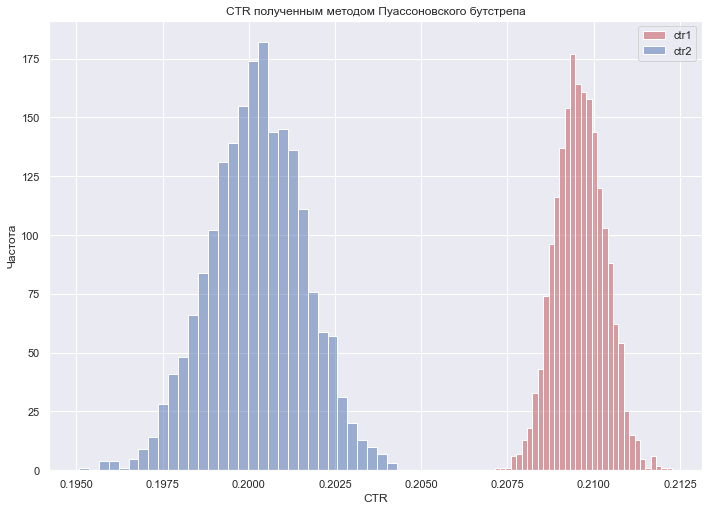

In [24]:
sns.histplot(ctr1, 
             kde = False, alpha=0.5, label='ctr1', color ='r')
sns.histplot(ctr2,
             kde = False, alpha=0.5, label='ctr2', color='b')

plt.xlabel('CTR')
plt.ylabel('Частота')
plt.legend()
plt.title('CTR полученным методом Пуассоновского бутстрепа')
plt.show()

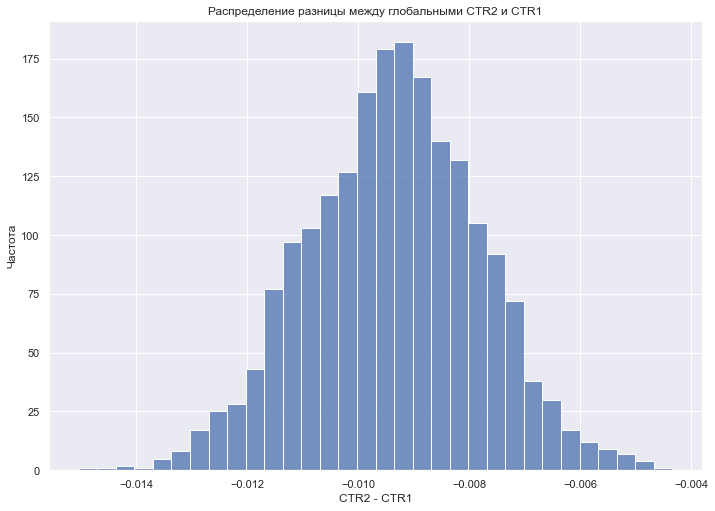

In [25]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1)
plt.xlabel('CTR2 - CTR1')
plt.ylabel('Частота')
plt.title('Распределение разницы между глобальными CTR2 и CTR1')
plt.show()

**Вывод:** Разница между глобальными CTR строго меньше нуля. Таким образом, с помощью бутсрепа мы выяснили, что группа 1 (контрольная) показала лучший результат по CTR, чем группа 2(рекомендации "похожих на лайкнутые постов").

### Бакетное преобразование

In [26]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-06-30' and '2023-07-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [27]:
result = stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

print(result)

if result.pvalue <= 0.05:
    print("Статистически значимые различия в среднем побакетном CTR между группами есть.")
else:
    print("Статистически значимых различий в среднем побакетном CTR между группами нет.") 

MannwhitneyuResult(statistic=1997.0, pvalue=2.657642780401009e-07)
Статистически значимые различия в среднем побакетном CTR между группами есть.


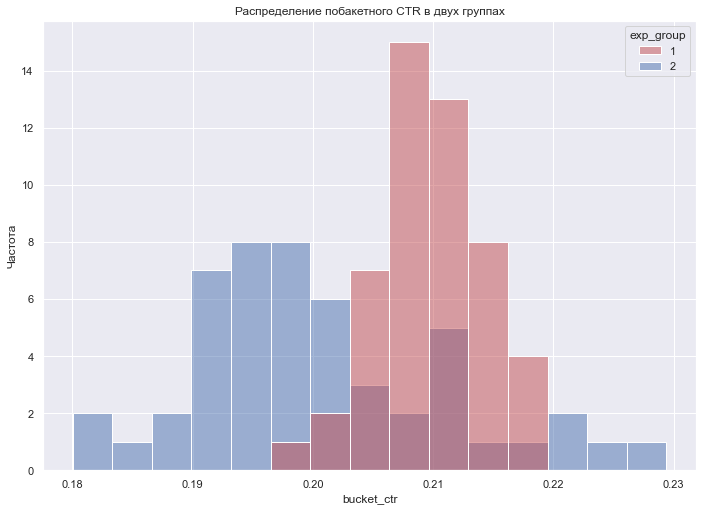

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x ='bucket_ctr', 
              hue ='exp_group', 
              palette = ['r', 'b'],
              alpha= 0.5,
              kde = False,
              bins=15)
plt.xlabel('bucket_ctr')
plt.ylabel('Частота')
plt.title('Распределение побакетного CTR в двух группах')
plt.show()

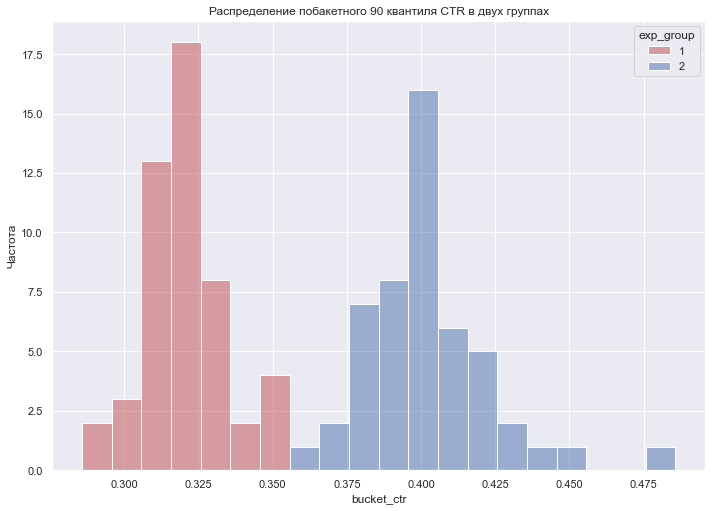

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x ='ctr9', 
              hue ='exp_group', 
              palette = ['r', 'b'],
              alpha= 0.5,
              kde = False,
              bins=20)
plt.xlabel('bucket_ctr')
plt.ylabel('Частота')
plt.title('Распределение побакетного 90 квантиля CTR в двух группах')
plt.show()

Проведем тест Манна-Уитни:


In [30]:
result = stats.mannwhitneyu(df[df.exp_group == 1].ctr9, 
                   df[df.exp_group == 2].ctr9, 
                   alternative = 'two-sided')

print(result)

if result.pvalue < 0.05:
    print("Статистически значимые различия в среднем побакетном 90 квантиле CTR между группами есть.")
else:
    print("Статистически значимых различий в среднем побакетном 90 квантиле CTR между группами нет.") 

MannwhitneyuResult(statistic=0.0, pvalue=6.7601631082665925e-18)
Статистически значимые различия в среднем побакетном 90 квантиле CTR между группами есть.


**Вывод:** Тест Манна-Уитни поверх бакетного преобразования показал значимые различия в CTR и 90 квантиле CTR.

# Выводы:

1. В результате 10 000 А/А- тестов p_value меньше или равно 0,05 не более, чем в 5% случаях. Данные результаты говорят в пользу того, что проведение дальнейших А/В-тестов с использованием этой системы сплитования будет надежным и достоверным способом оценки влияния изменений на поведение пользователей.

2. Анализ результата А/В- теста:
    * t-тест не показал статистически значимых различий в CTR двух групп.
    * Тест Манна-Уитни показал статистически значимые различия в СТR.
    * Пуассоновским бутстрепом получили, что разница между глобальными CTR строго меньше нуля. Таким образом, группа 1 (контрольная) показала лучший результат по CTR, чем группа 2 (рекомендации "похожих на лайкнутые постов").
    * Тест Манна-Уитни поверх бакетного преобразования показал значимые различия в CTR и 90 квантиле CTR.
    * Распределение CTR 2 группы пользователей имеет два ярко выраженных пика.


*CTR второй группы ниже в сравнении с контрольной.* Возможные причины:
- недоработка алгоритма рекомендаций: возможно, новый алгоритм рекомендаций "похожих на лайкнутые посты" требует оптимизации или учета дополнительных факторов, которые влияют на рекомендации;
- отсутствием истории лайков у новых пользователей;
- сравнение с уже существующим алгоритмом: группа 1 могла использовать определенный алгоритм рекомендаций, который уже хорошо справляется с задачей, поэтому новый алгоритм во второй группе не показал столь же высоких результатов.

На основе результатов анализа А/В-теста и проведенных статистических тестов: **не рекомендуется раскатывать новый алгоритм рекомендаций "похожих на лайкнутые посты" в текущем виде на всех новых пользователей.**